# Discrete time long range dispersal model

This notebook simulates the evolution of a three-species system in a discrete-time setting with long-range dispersal.

Importing the necessary libraries:

In [1]:
import numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import colormaps
np.random.seed(0)

## Finite population model

We consider a model world that has $N$ available sites. The sites are occupied by three species, namely species $r$ (rock), $s$ (scissors) and $p$ (paper), which occur in the proportions $n_r$ , $n_s$ and $n_p$ (with $n_r + n_s + n_p = 1$). Two sites are chosen at each time-step. The occupant of the first replicates into the second with a given probability - individual of species $r$ can invade a species $s$ with probability $P_r$, a species $s$ invades a species $p$ with probability $P_s$, a species $p$ invades a species $r$ with probability $P_p$ and all other invasion probabilities are zero.

Defining a function to simulate the evolution of the system for a world with $N$ sites:

In [2]:
def simulate_finite_N(Pr, Ps, Pp, nr_init, ns_init, N=1000, epochs=100):
    '''
    Simulate the evolution of a population of three species over time
    on a model world that has N available sites.

    Parameters
    ----------
    Pr : float
        The probability that a species of type r invades a species of type s.
    Ps : float
        The probability that a species of type s invades a species of type p.
    Pp : float
        The probability that a species of type p invades a species of type r.
    nr_init : float
        The initial proportion of species r in the population.
    ns_init : float
        The initial proportion of species s in the population.
    N : int
        The number of sites.
    epochs : int
        The number of time units to simulate.
    '''

    def check_P(P):
        if P < 0 or P > 1:
            raise ValueError('Pr, Ps and Pp must be between 0 and 1')
        
    check_P(Pr)
    check_P(Ps)
    check_P(Pp)
    
    if nr_init + ns_init > 1:
        raise ValueError('Initial species proportions must be less than 1')
    
    if N < 1:
        raise ValueError('Number of sites must be at least 1')
    
    if epochs < 1:
        raise ValueError('Number of steps must be at least 1')
    
    sites = numpy.zeros(N)

    nr = []
    ns = []
    np = []

    r_id = 1
    s_id = 2
    p_id = 3

    # Initialize the sites
    for i in range(N):
        sites[i] = numpy.random.choice([r_id, s_id, p_id], p=[nr_init, ns_init, 1-nr_init-ns_init])

    nr.append(numpy.sum(sites == r_id) / N)
    ns.append(numpy.sum(sites == s_id) / N)
    np.append(numpy.sum(sites == p_id) / N)

    for t in range(1, epochs):
        for step in range(N):
            # choose two random sites
            i = numpy.random.randint(0, N)
            j = numpy.random.randint(0, N)
            
            if sites[i] == r_id and sites[j] == s_id: # rock beats scissors
                if numpy.random.rand() < Pr:
                    sites[j] = r_id
            elif sites[i] == s_id and sites[j] == p_id: # scissors beats paper
                if numpy.random.rand() < Ps:
                    sites[j] = s_id
            elif sites[i] == p_id and sites[j] == r_id: # paper beats rock
                if numpy.random.rand() < Pp:
                    sites[j] = p_id
        
        nr.append(numpy.sum(sites == r_id) / N)
        ns.append(numpy.sum(sites == s_id) / N)
        np.append(numpy.sum(sites == p_id) / N)

        # if two species go extinct, stop the simulation
        if sum([numpy.isclose(nr[-1], 0, 1e-4),
                numpy.isclose(ns[-1], 0, 1e-4),
                numpy.isclose(np[-1], 0, 1e-4)
            ]) >= 2:
            break
    
    return pd.DataFrame({'$n_r$': nr, '$n_s$': ns, '$n_p$': np})

Defining functions to plot the evolution of the system:

In [3]:
def line_plot_species_evolution(df, title=None, show_markers=True):
    '''
    Plot the evolution of species proportions over time in a line plot.

    Parameters
    ----------
    df : pd.DataFrame
        A DataFrame containing the species proportions over time.
    title : str
        The title of the plot.
    '''
    ax = df.plot(
        figsize=(12, 4),
        style='o-' if show_markers else '-', color=['tab:red', 'purple', 'gold'],
        title=title
    );
    if show_markers:
        for line in ax.get_lines():
            line.set_markeredgecolor('black')

def phase_plot_species_evolution(df, title=None):
    '''
    Plot the evolution of species proportions over time in a phase plot.

    Parameters
    ----------
    df : pd.DataFrame
        A DataFrame containing the species proportions over time.
    title : str
        The title of the plot.
    '''
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)
    cmap = colormaps['Blues']
    colors = cmap(np.linspace(0, 1, (df['$n_r$'].shape[0]-1))) 
    axs[0].plot(df['$n_r$'][0:-1], df['$n_r$'][1:], '-', color='k', zorder=1)
    axs[0].scatter(df['$n_r$'][0:-1], df['$n_r$'][1:], c=colors, s=50, zorder=2, edgecolor='black')
    axs[0].set_title('$n_r$')
    axs[1].plot(df['$n_s$'][0:-1], df['$n_s$'][1:], '-', label='$n_s$', color='k', zorder=1)
    axs[1].scatter(df['$n_s$'][0:-1], df['$n_s$'][1:], c=colors, s=50, zorder=2, edgecolor='black')
    axs[1].set_title('$n_s$')
    axs[2].plot(df['$n_p$'][0:-1], df['$n_p$'][1:], '-', color='k', zorder=1)
    axs[2].scatter(df['$n_p$'][0:-1], df['$n_p$'][1:], c=colors, s=50, zorder=2, edgecolor='black') 
    axs[2].set_title('$n_p$')
    fig.suptitle(title);
    fig.tight_layout()

def ternary_plot_species_evolution(df, title=None, show_markers=True):
    '''
    Plot the evolution of species proportions over time in a ternary plot.
    
    Parameters
    ----------
    df : pd.DataFrame
        A DataFrame containing the species proportions over time.
    title : str
        The title of the plot.
    '''
    fig = px.scatter_ternary(
        df,
        a="$n_p$",
        b="$n_r$",
        c="$n_s$",
        color=df.index,
        color_continuous_scale='blues',
        size_max=10,
        title=title
    )
    if show_markers:
        fig.update_traces(mode='lines+markers', line=dict(color='black', width=1),
            marker=dict(symbol='circle', line=dict(width=1, color='black')))
    else:
        fig.update_traces(mode='lines', line=dict(color='black', width=1))
    fig.update_layout(coloraxis_colorbar=dict(title='Time'))
    fig.show('png')

Simulating the evolution of the system with $P_r = 0.2$, $P_s = 0.5$, $P_p = 0.3$, $N = 100$ initialized with population densities close to the fixed point ($n_r=0.5$, $n_s=0.3$, $n_p=0.2$):

In [4]:
fp_finite_N_df = simulate_finite_N(Pr=0.2, Ps=0.5, Pp=0.3, nr_init=0.5, ns_init=0.3, N=1000, epochs=1000)

Plotting the evolution of the system:

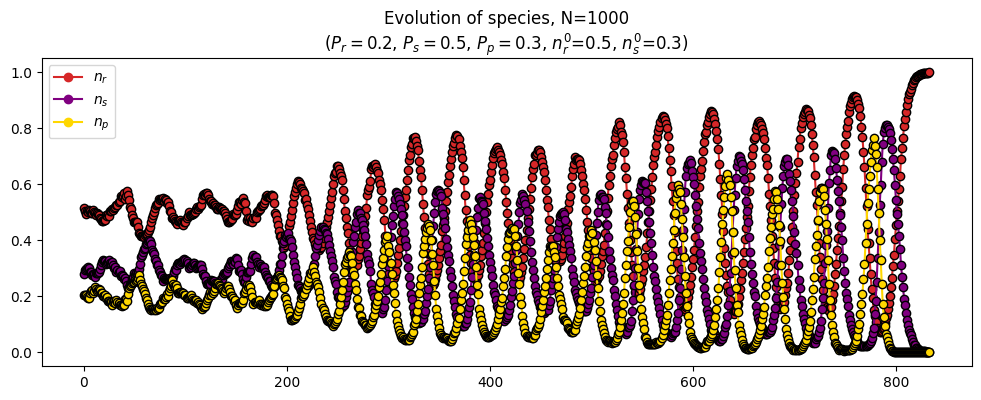

In [5]:
line_plot_species_evolution(
    fp_finite_N_df,
    title='Evolution of species, N=1000\n($P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $n_r^0$=0.5, $n_s^0$=0.3)'
)

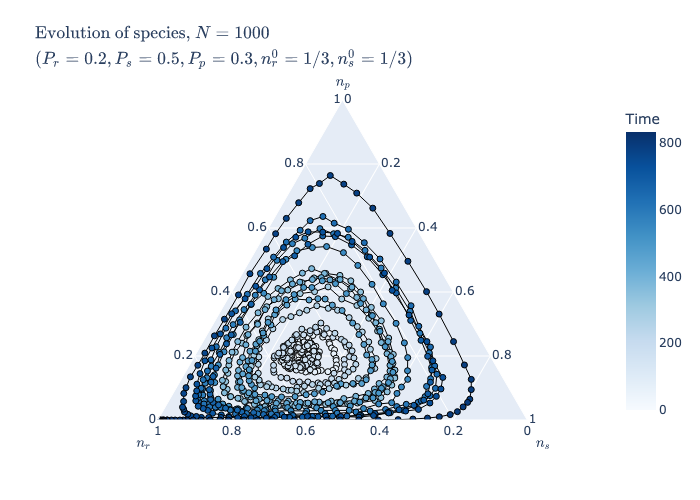

In [6]:
ternary_plot_species_evolution(
    fp_finite_N_df,
    title=r"$\text{Evolution of species, }N=1000\\(P_r=0.2, P_s=0.5, P_p=0.3, n_r^0=1/3, n_s^0=1/3)$"
)

In a finite world, the populations move from orbit to orbit, with two species (scissors and paper) eventually becoming extinct. The species that survives (rock) is the one that has the lowest invasion rate.

Performing simulations for a range of invasion probabilities chosen to sum to unity, initializing the population densities close to the fixed point and recording the surviving species:

In [7]:
# defining a grid of points for invasion probabilities
R, S = np.mgrid[0:1:20j, 0:1:20j]
R, S = R.ravel(), S.ravel()
P = 1 - R - S
I = np.array([R, S, P]).T
# keeping only invasion probabilities greater than 0.01
I = I[np.all(I > 0.01, axis=1)]
R = I[:, 0]
S = I[:, 1]
P = I[:, 2]
# total number of simulations to run
num_sim = len(I)
# number of sites 
N = 1000
# maximum number of iterations
EPOCHS = 2000
# list to store the winner of each simulation
winners = []

# iterating over the invasion probabilities
for i, (Pr, Ps, Pp) in enumerate(I):
    print(f"[{i+1}/{num_sim}] Running simulation for invasion probabilities: Pr={Pr:.2f}, Ps={Ps:.2f}, Pp={Pp:.2f}")
    # simulating with the current invasion probabilities
    results_df = simulate_finite_N(
        Pr=Pr, Ps=Ps, Pp=Pp,
        nr_init=Ps, ns_init=Pp,
        N=N, epochs=EPOCHS
    )
    # storing the winner
    if results_df.index.stop==EPOCHS: # no winner
        winners.append('None')
    elif np.isclose(results_df.iloc[-1]['$n_r$'], 1, 1e-4): # rock wins
            winners.append('Rock')
    elif np.isclose(results_df.iloc[-1]['$n_s$'], 1, 1e-4): # scissors wins
        winners.append('Scissors')
    else: # paper wins
        winners.append('Paper')

[1/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.05, Pp=0.89
[2/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.11, Pp=0.84
[3/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.16, Pp=0.79
[4/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.21, Pp=0.74
[5/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.26, Pp=0.68
[6/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.32, Pp=0.63
[7/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.37, Pp=0.58
[8/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.42, Pp=0.53
[9/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.47, Pp=0.47
[10/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.53, Pp=0.42
[11/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.58, Pp=0.37
[12/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.63, Pp=0.32
[13/153] Running simulati

Plotting the surviving species on a ternary plot:

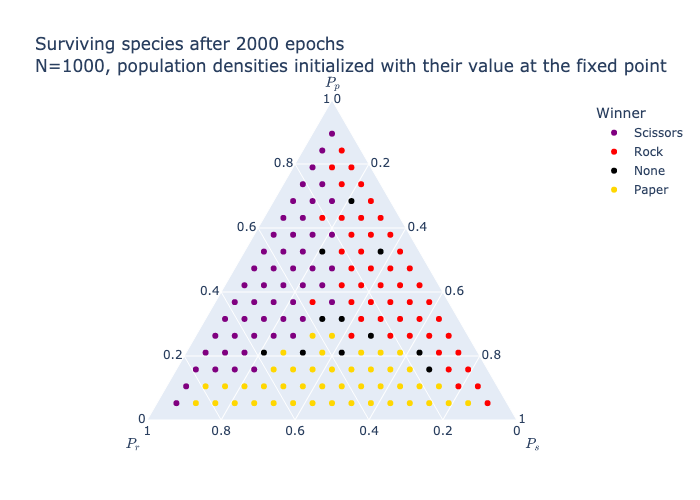

In [8]:
fig = px.scatter_ternary(
    pd.DataFrame(I, columns=['$P_r$', '$P_s$', '$P_p$']),
    a="$P_p$",
    b="$P_r$",
    c="$P_s$",
    size_max=10,
    title=f"Surviving species after {EPOCHS} epochs<br>N={N}, population densities initialized with their value at the fixed point",
    color = winners,
    color_discrete_map={'None': 'black', 'Rock': 'red', 'Scissors': 'purple', 'Paper': 'gold'}
    )
fig.update_layout(legend_title_text='Winner')
fig.show('png')

The weakest competitor is most likely to survive.

## Model for large population size

In the limit of large $N$, the rate of change of species population density is given by the mean-field equations:

\begin{cases}
\frac{\partial n_r}{\partial t}=n_r\cdot (n_s\cdot P_r - n_p \cdot P_p)\\
\frac{\partial n_s}{\partial t}=n_s\cdot (n_p\cdot P_s - n_r \cdot P_r)\\
\frac{\partial n_p}{\partial t}=n_p\cdot (n_r\cdot P_p - n_s \cdot P_s)\\
\end{cases}
Here a unit of time $t$ is $N$ individual time-steps, which we refer to as an epoch.

This leads to the following recurrence equations
$$n_r[t+1]=n_r[t] + n_r[t](n_s[t]P_r - n_p[t] P_p)$$
$$n_s[t+1]=n_s[t] + n_s[t](n_p[t]P_s - n_r[t] P_r)$$
$$n_p[t+1]=n_p[t] + n_p[t](n_r[t]P_p - n_s[t] P_s)$$

Defining a function to simulate the evolution of the system under the large $N$ assumption:

In [9]:
def simulate_large_N(Pr, Ps, Pp, nr_init, ns_init, delta_t=0.001, epochs=1000):
    '''
    Simulate the evolution of a population of three species over time using 
    the recurrence relations under the large N assumption.

    Parameters
    ----------
    Pr : float
        The probability that a species of type r invades a species of type s.
    Ps : float
        The probability that a species of type s invades a species of type p.
    Pp : float
        The probability that a species of type p invades a species of type r.
    nr_init : float
        The initial proportion of species r in the population.
    ns_init : float
        The initial proportion of species s in the population.
    delta_t : float
        The time step size.
    epochs : int
        The number of time units to simulate.
    '''

    def check_P(P):
        if P < 0 or P > 1:
            raise ValueError('Pr, Ps and Pp must be between 0 and 1')
        
    check_P(Pr)
    check_P(Ps)
    check_P(Pp)
    
    if nr_init + ns_init > 1:
        raise ValueError('Initial species proportions must be less than 1')
    
    if epochs < 1:
        raise ValueError('Number of steps must be at least 1')
    
    nr = []
    ns = []
    np = []

    nr.append(nr_init)
    ns.append(ns_init)
    np.append(1 - nr_init - ns_init)

    for _ in range(0, epochs-1):
        nr.append(nr[-1] + nr[-1]*delta_t*(ns[-1]*Pr - np[-1]*Pp))
        ns.append(ns[-1] + ns[-1]*delta_t*(np[-1]*Ps - nr[-2]*Pr)) # use nr from the previous time step
        np.append(1 - nr[-1] - ns[-1])

        # if two species go extinct, stop the simulation
        if sum([numpy.isclose(nr[-1], 0, 1e-4),
                numpy.isclose(ns[-1], 0, 1e-4),
                numpy.isclose(np[-1], 0, 1e-4)]) >= 2:
            break
    
    return pd.DataFrame({'$n_r$': nr, '$n_s$': ns, '$n_p$': np})

Trivial fixed points of the system are ($n_r=0, n_s=0, n_p=1$), ($n_r=0, n_s=1, n_p=0$) and ($n_r=1, n_s=0, n_p=0$).

The non-trivial fixed point is obtained by setting the rates of change to zero:

\begin{cases}
\frac{\partial n_r}{\partial t}=n_r\cdot (n_s\cdot P_r - n_p \cdot P_p)=0 \implies n_p = \frac{n_s\cdot P_r}{P_p}&\text{(1)}\\
\frac{\partial n_s}{\partial t}=n_s\cdot (n_p\cdot P_s - n_r \cdot P_r)=0 \implies n_r = \frac{n_p\cdot P_s}{P_r}&\text{(2)}\\
n_r+n_s+n_p=1 \implies n_s = 1-n_p-n_r&\text{(3)}\\
\end{cases}

$$\implies$$

\begin{cases}
n_r = \frac{n_s \cdot \cancel{P_r}\cdot P_s}{P_p\cdot \cancel{P_r}}&\text{(4), substituting (1) into (2)}\\
n_s = 1-\frac{n_s\cdot P_r}{P_p}-nr&\text{(5), substituting (1) into (3)}\\
\end{cases}

$$\implies$$

\begin{cases}
n_s=1-\frac{n_s\cdot P_r}{P_p}-\frac{n_s\cdot P_s}{P_p}\implies n_s=\frac{P_p}{P_p+P_r+P_s}&\text{(6), substituting (4) into (5)}\\
n_p=\frac{n_s\cdot P_r}{P_p}=\frac{\cancel{P_p}\cdot P_r}{\cancel{P_p}\cdot (P_p+P_r+P_s)}=\frac{P_r}{P_p+P_r+P_s}&\text{(7), substituting (6) into (1)}\\
n_r=\frac{n_p\cdot P_s}{P_r}=\frac{\cancel{P_r}\cdot P_s}{\cancel{P_r}\cdot (P_p+P_r+P_s)}=\frac{P_s}{P_p+P_r+P_s}&\text{(8), substituting (7) into (2)}\\
\end{cases}


Simulating the evolution of the system under the large N assumption with $P_r = 0.2$, $P_s = 0.5$, $P_p = 0.3$ initialized with population densities close to the fixed point ($n_r=0.5$, $n_s=0.3$, $n_p=0.2$):

In [10]:
fp_large_N_df = simulate_large_N(Pr=0.2, Ps=0.5, Pp=0.3, nr_init=0.5, ns_init=0.3, epochs=100)

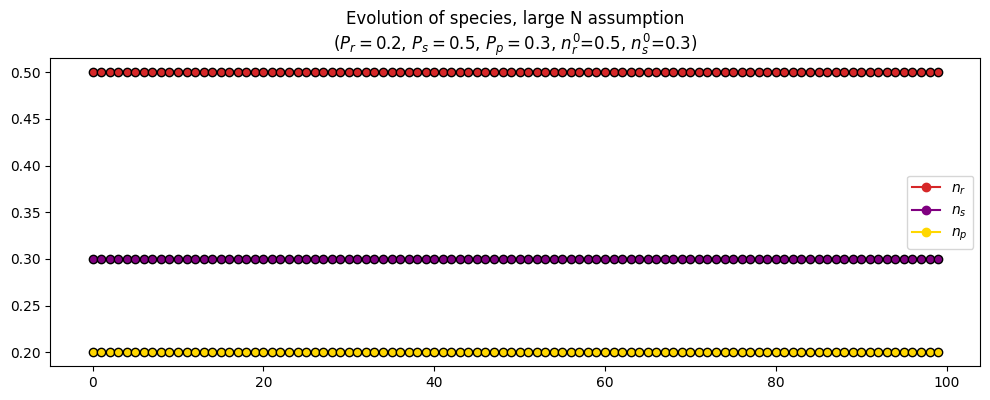

In [11]:
line_plot_species_evolution(
    fp_large_N_df,
    title='Evolution of species, large N assumption\n($P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $n_r^0$=0.5, $n_s^0$=0.3)'
)

Initializing the population densities equal to the fixed point ($n_r=1/3$, $n_s=1/3$, $n_p=1/3), the system remains at the fixed point.

Simulating the evolution of the system under the large N assumption with $P_r = 0.2$, $P_s = 0.5$, $P_p = 0.3$, initialized with equal population densities ($n_r=1/3$, $n_s=1/3$, $n_p=1/3$) and using $\Delta_t=1$:

In [12]:
eq_large_N_df = simulate_large_N(Pr=0.2, Ps=0.5, Pp=0.3, nr_init=1/3, ns_init=1/3, delta_t=1, epochs=1000)

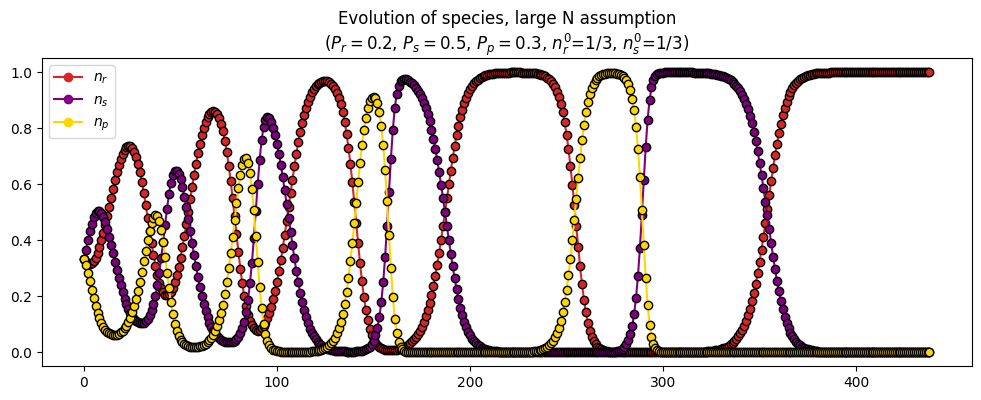

In [13]:
line_plot_species_evolution(
    eq_large_N_df,
    title='Evolution of species, large N assumption\n($P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $n_r^0$=1/3, $n_s^0$=1/3)'
)

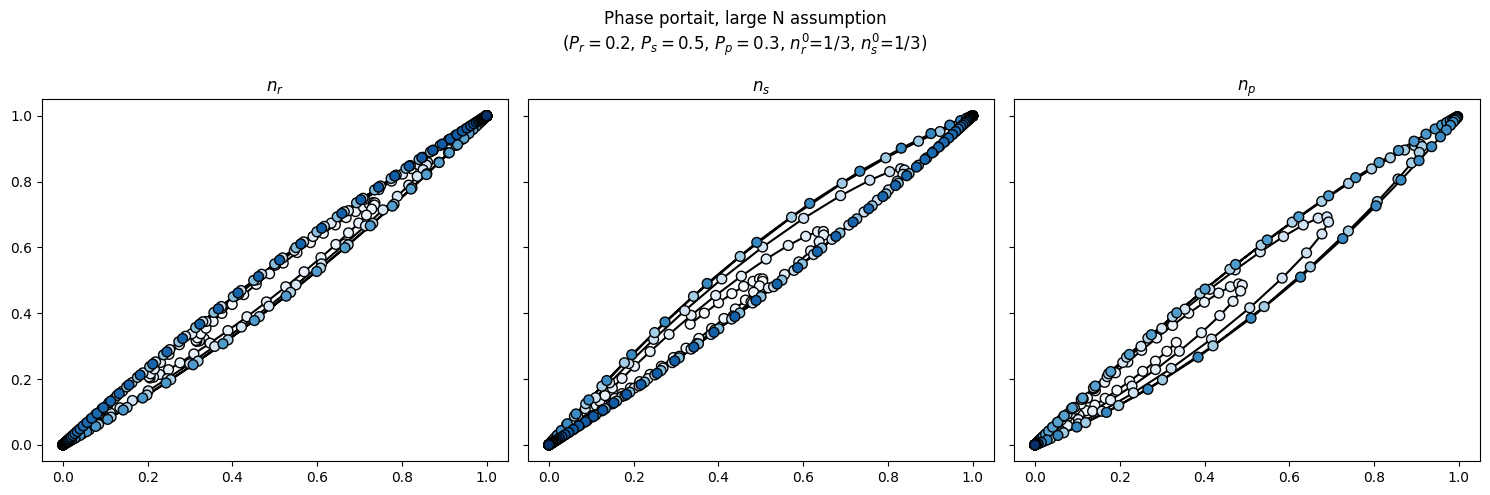

In [14]:
phase_plot_species_evolution(
    eq_large_N_df,
    title='Phase portait, large N assumption\n($P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $n_r^0$=1/3, $n_s^0$=1/3)'
)

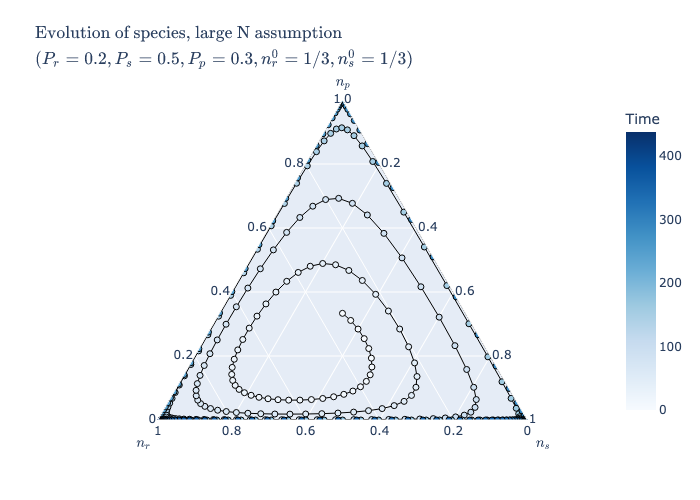

In [15]:
ternary_plot_species_evolution(
    eq_large_N_df,
    title=r"$\text{Evolution of species, large N assumption}\\(P_r=0.2, P_s=0.5, P_p=0.3, n_r^0=1/3, n_s^0=1/3)$"
)

Using $\Delta_t=0.01$ to increase accuracy:

In [16]:
eq_large_N_df = simulate_large_N(Pr=0.2, Ps=0.5, Pp=0.3, nr_init=1/3, ns_init=1/3, delta_t=0.01, epochs=100000)

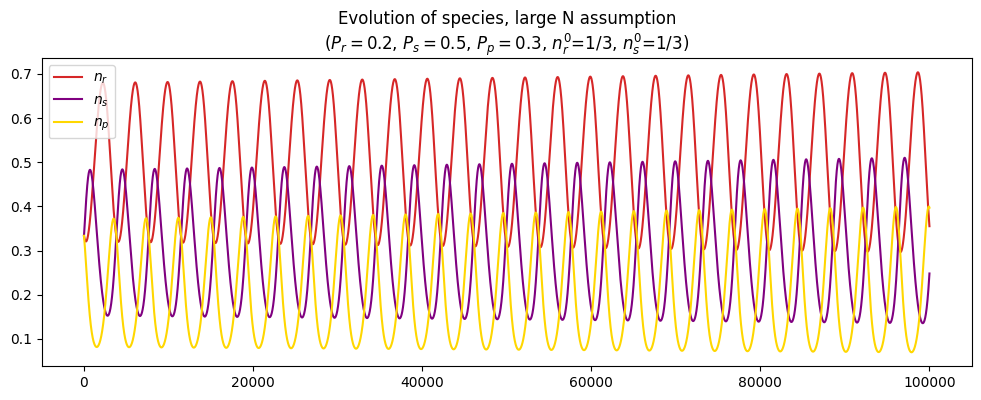

In [17]:
line_plot_species_evolution(
    eq_large_N_df,
    title='Evolution of species, large N assumption\n($P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $n_r^0$=1/3, $n_s^0$=1/3)',
    show_markers=False
)

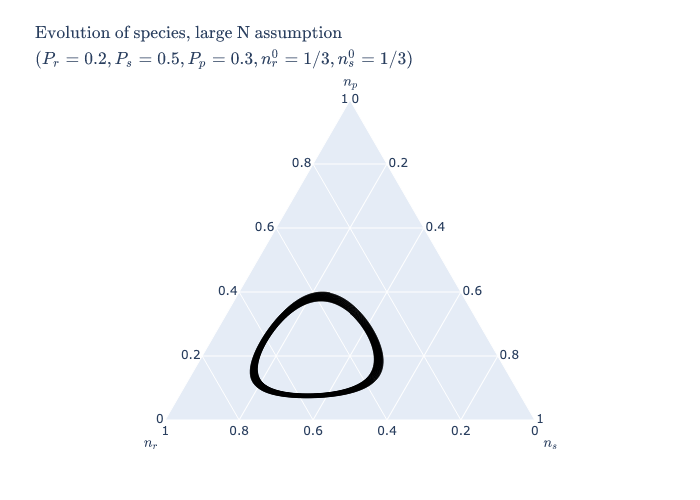

In [18]:
ternary_plot_species_evolution(
    eq_large_N_df,
    title=r"$\text{Evolution of species, large N assumption}\\(P_r=0.2, P_s=0.5, P_p=0.3, n_r^0=1/3, n_s^0=1/3)$",
    show_markers=False
)

In the limit that the total number of sites is large the populations move along a periodic orbit around the fixed point.